In [371]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [372]:
df=pd.read_csv('Space_Corrected.csv')

In [373]:
df=df.iloc[:,2:]

In [374]:
df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


In [375]:
df['Status Rocket'] = df['Status Rocket'].str.replace('Status', '')

In [376]:
def extract_state_country(location):
    parts = location.split(',')
    country = parts[-1].strip()
    state = parts[-2].strip()
    return pd.Series([state, country])

df[['state', 'country']] = df['Location'].apply(extract_state_country)

In [377]:
df[['Rocket Type', 'Payload']] = df['Detail'].str.split('|', expand=True)


In [378]:
df['Rocket Type'].unique()

array(['Falcon 9 Block 5 ', 'Long March 2D ', 'Starship Prototype ',
       'Proton-M/Briz-M ', 'Atlas V 541 ', 'Long March 4B ',
       'Soyuz 2.1a ', 'Long March 5 ', 'H-IIA 202 ', 'Minotaur IV ',
       'Kuaizhou 11 ', 'Long March 3B/E ', 'Shavit-2 ', 'Electron/Curie ',
       'Long March 2C ', 'Long March 11 ', 'LauncherOne ',
       'Soyuz 2.1b/Fregat-M ', 'H-IIB ', 'Atlas V 501 ', 'Kuaizhou 1A ',
       'Long March 5B ', 'Qased ', 'Atlas V 551 ', 'Soyuz 2.1b/Fregat ',
       'Long March 7A ', 'Soyuz 2.1a/Fregat-M ', 'Ariane 5 ECA ',
       'Antares 230+ ', 'Atlas V 411 ', 'Simorgh ', 'Rokot/Briz KM ',
       'Proton-M/DM-3 ', 'Atlas V N22 ', 'Soyuz ST-A/Fregat-M ',
       'Long March 3B/YZ-1 ', 'New Shepard ', 'PSLV-QL ',
       'Long March 4C ', 'PSLV-XL ', 'Soyuz 2.1v/Volga ', 'Long March 6 ',
       'SARGE ', 'Pegasus XL ', 'Soyuz FG ', 'Safir-1B+ ',
       'Delta IV Medium+ (4,2) ', 'Jielong-1 ', 'Hyperbola-1 ',
       'GSLV Mk III ', 'Vega ', 'Falcon Heavy ', 'Long March 11H

In [379]:
mapping_df = pd.read_excel('Rocket Type.xlsx')

In [380]:
df = df.merge(mapping_df, on='Rocket Type', how='left')

In [381]:
df['Parsed Datum'] = pd.to_datetime(df['Datum'], format='%a %b %d, %Y %H:%M %Z', errors='coerce')

# Second attempt for those that failed to parse in the first attempt
mask = df['Parsed Datum'].isna()  # Mask for where the first parsing failed
df.loc[mask, 'Parsed Datum'] = pd.to_datetime(df.loc[mask, 'Datum'], format='%a %b %d, %Y', errors='coerce')

df['Datum']=df['Parsed Datum']
df.drop(columns=['Parsed Datum'], inplace=True)
# Extracting year, month, and season
df['Datum'] = pd.to_datetime(df['Datum'], utc=True).dt.tz_localize(None)

df['Year'] = df['Datum'].dt.year

df['Month'] = df['Datum'].dt.month_name()
df['Season'] = df['Datum'].dt.month % 12 // 3 + 1
df['Season'] = df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

df['Decade'] = (df['Year'] // 10) * 10  # Creating bins by decade


In [382]:
df[' Rocket'].head()

0     50.0 
1    29.75 
2       NaN
3     65.0 
4    145.0 
Name:  Rocket, dtype: object

In [383]:
#remove comma and redundant space
df[' Rocket'] = df[' Rocket'].str.strip()
df[' Rocket'] = df[' Rocket'].str.replace(',', '')
df['Rocket'] = pd.to_numeric(df[' Rocket'])

Check missing value counts

In [384]:
df['Rocket'].isnull().sum()

3364

In [385]:
df_clean_rocketcost = df['Rocket'].dropna()

## Data Visualization

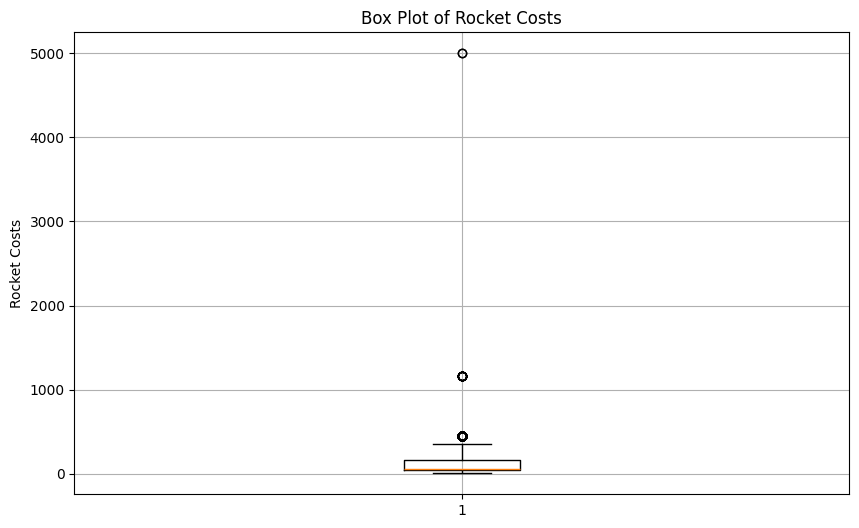

In [386]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_clean_rocketcost)
plt.title('Box Plot of Rocket Costs')
plt.ylabel('Rocket Costs')
plt.grid(True)
plt.show()

In [387]:
df_clean_rocketcost.describe()

count     964.000000
mean      153.792199
std       288.450732
min         5.300000
25%        40.000000
50%        62.000000
75%       164.000000
max      5000.000000
Name: Rocket, dtype: float64

In [388]:
df_filtered = df_clean_rocketcost[df_clean_rocketcost<1000]

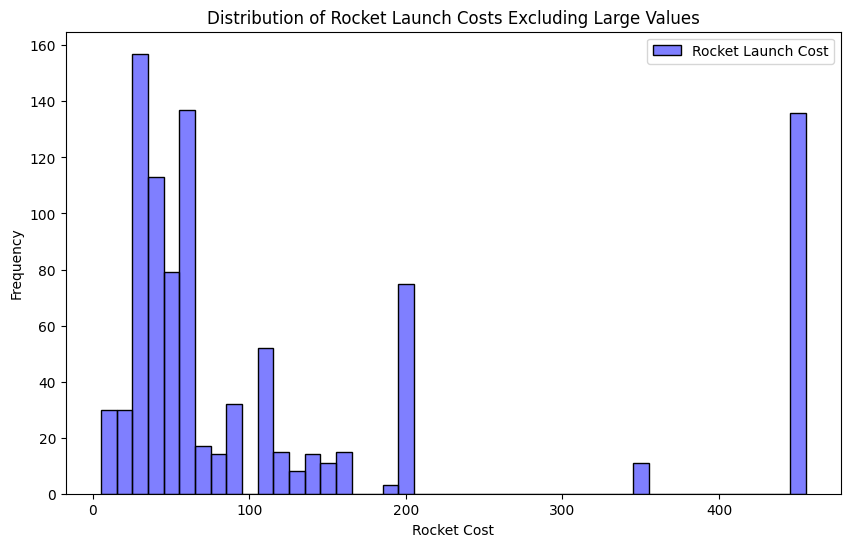

In [389]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, color='blue', binwidth=10,
             label='Rocket Launch Cost', alpha=0.5)

# Adding a title and other labels
plt.title('Distribution of Rocket Launch Costs Excluding Large Values')
plt.xlabel('Rocket Cost')
plt.ylabel('Frequency')
plt.legend()  # Show the legend
plt.show()

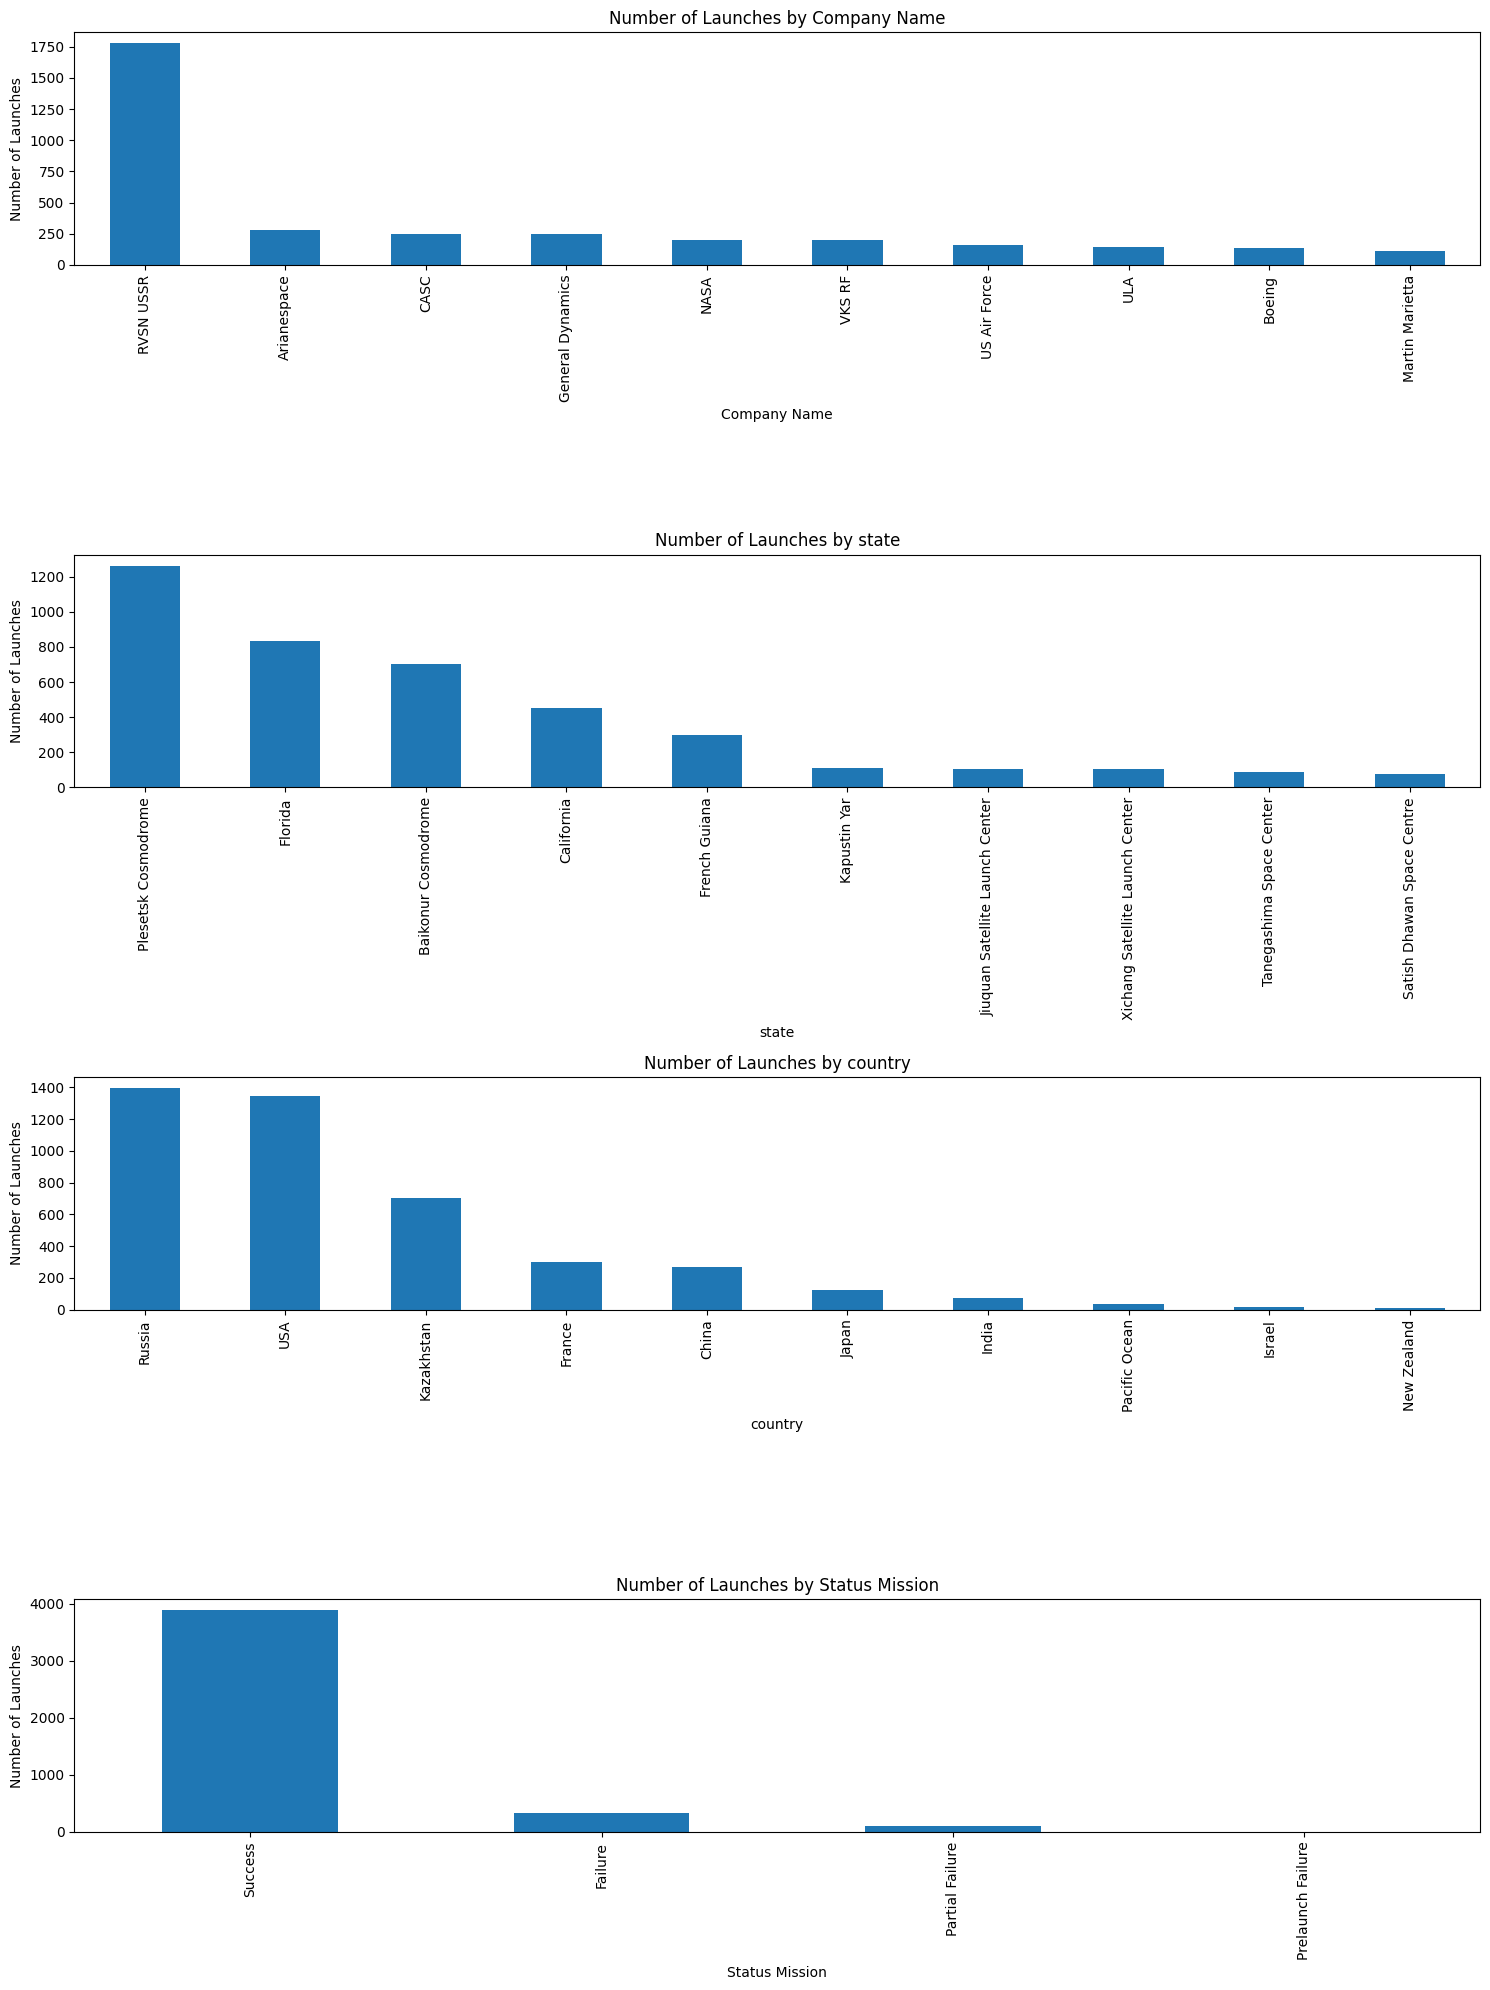

In [390]:
def create_bar_charts(dataframe, columns):
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, 5 * len(columns)))

    if len(columns) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, column in zip(axes, columns):
        counts = dataframe[column].value_counts().head(10)
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Number of Launches by {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Number of Launches')

    plt.tight_layout()
    plt.show()

# Specify the columns to visualize
columns_to_visualize = ['Company Name', 'state', 'country','Status Mission']

# Create bar charts
create_bar_charts(df, columns_to_visualize)

In [391]:
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

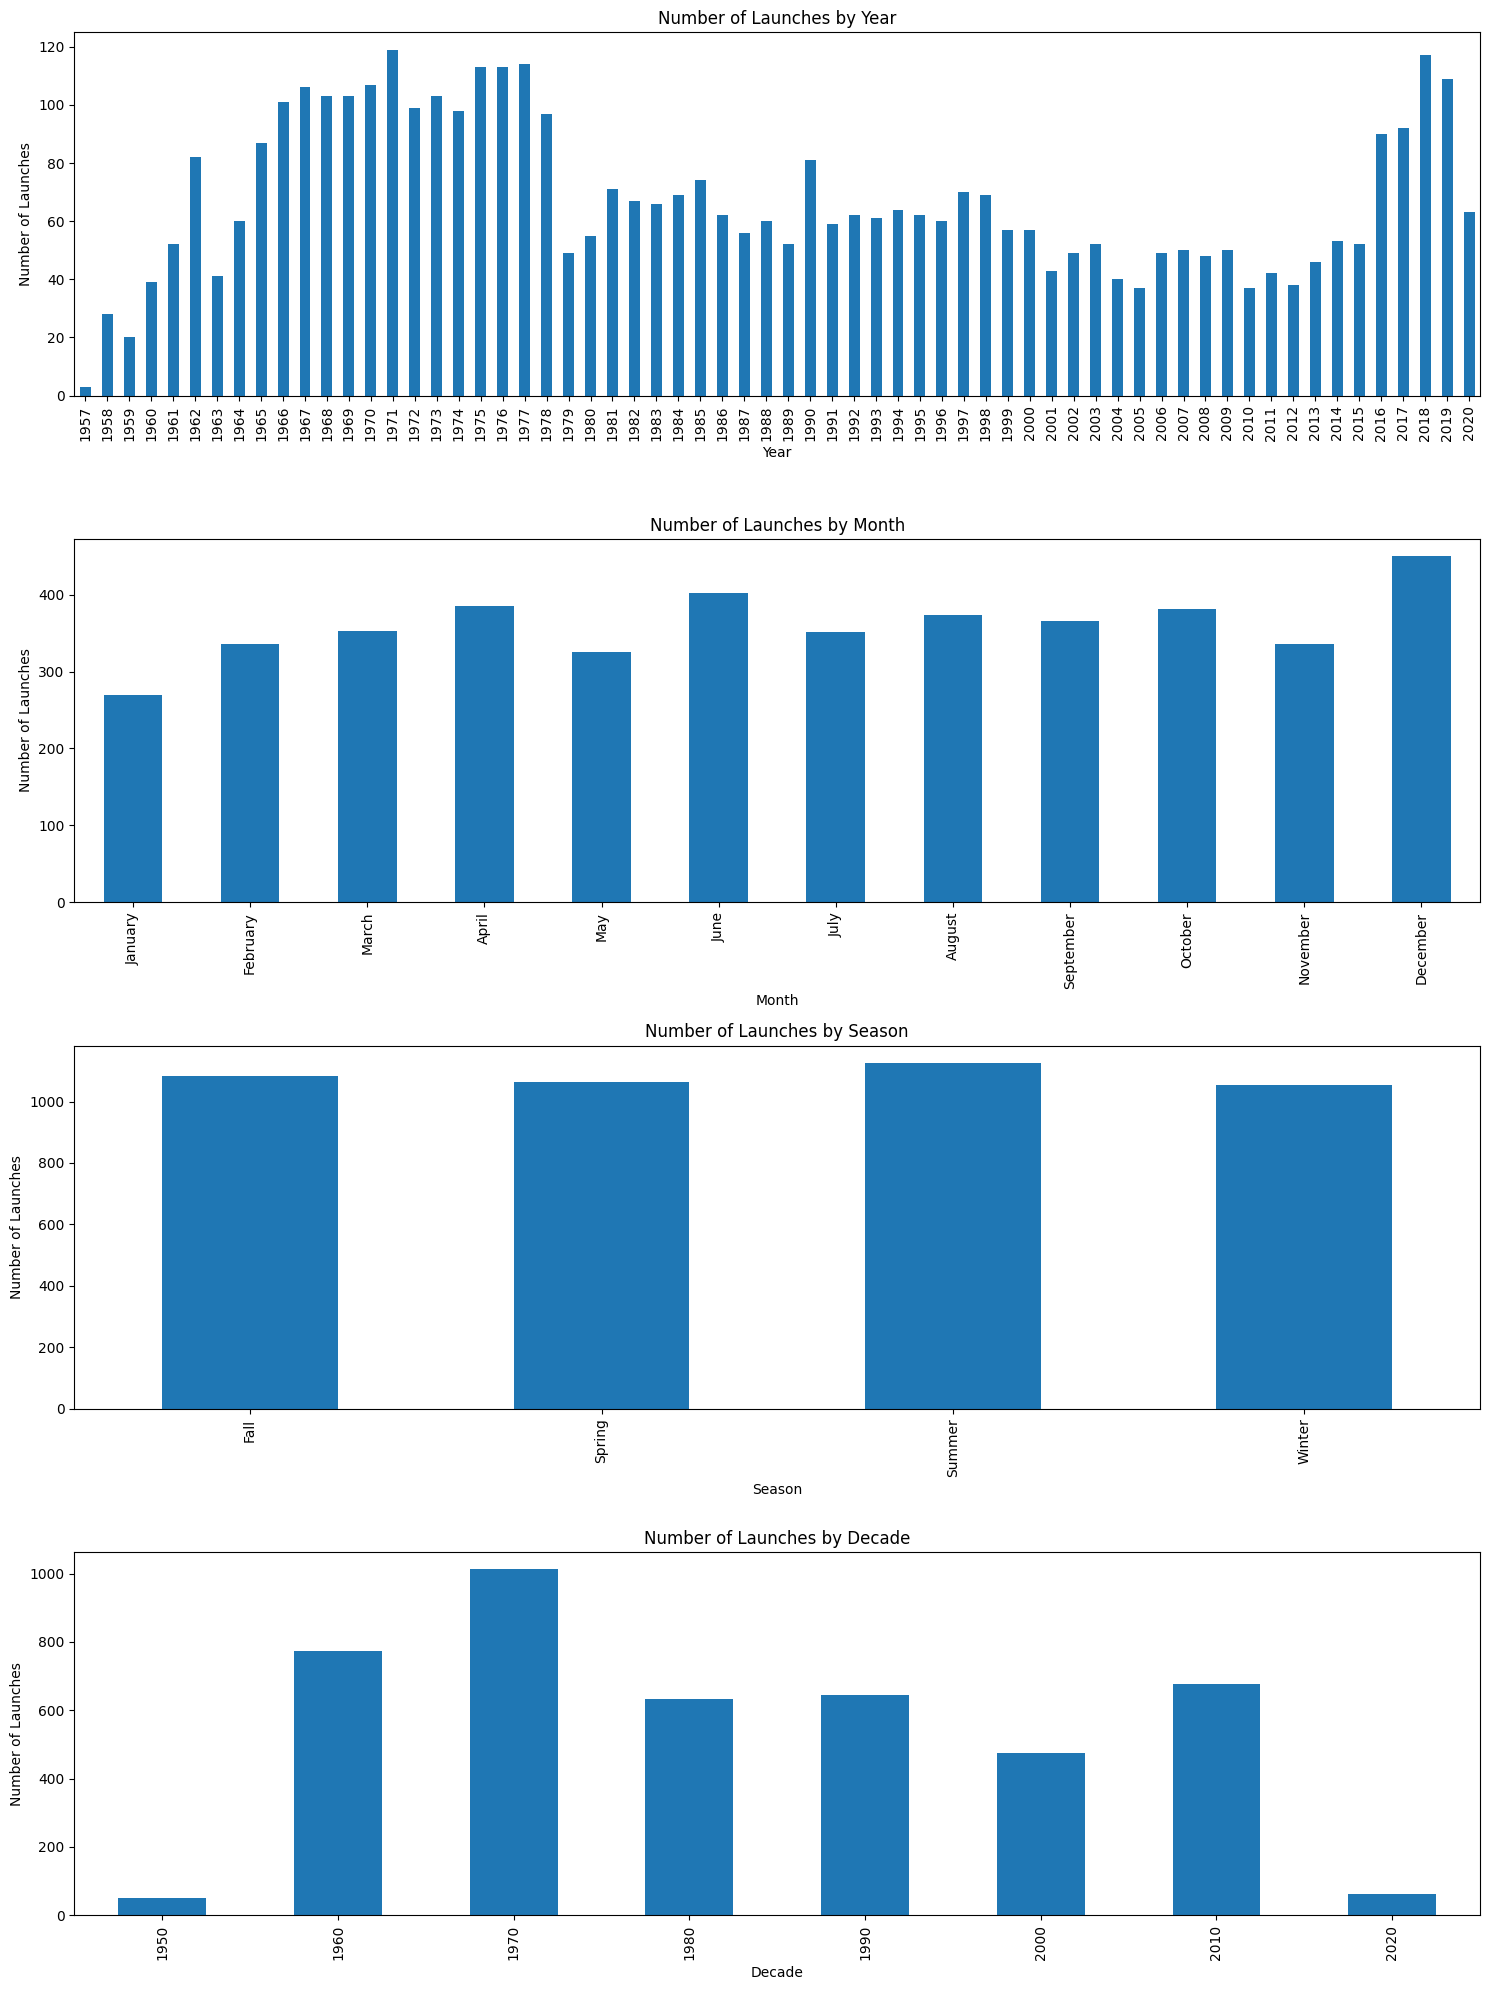

In [392]:
def create_time_bar_charts(dataframe, time_columns):
    fig, axes = plt.subplots(len(time_columns), 1, figsize=(15, 5 * len(time_columns)))

    if len(time_columns) == 1:
        axes = [axes]

    for ax, column in zip(axes, time_columns):
        counts = dataframe[column].value_counts().sort_index()
        counts.plot(kind='bar', ax=ax)
        ax.set_title(f'Number of Launches by {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Number of Launches')

    plt.tight_layout()
    plt.show()

time_columns_to_visualize = ['Year', 'Month', 'Season','Decade']

# Create time-based bar charts
create_time_bar_charts(df, time_columns_to_visualize)

## Exploratory Data Analysis

In [393]:
from collections import Counter
col_counts = Counter(df['Status Mission'])

print(col_counts)


Counter({'Success': 3882, 'Failure': 340, 'Partial Failure': 102, 'Prelaunch Failure': 4})


### Imbalance dataset
We can find that most cases are successful, only few of the datasets are failure or partial failure. Since their are not only binary results, we can consider few possibility for future feature engineering. For example, make these value into numeric values, that is to say 1, 0.5, 0 , so to enable regression model. Other opportunity include binary, just success and not success, so as to enable classification model. We may explore and evaluate in the following week.

## Modelling

In [394]:
df

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,state,country,Rocket Type,Payload,Rocket Category,Year,Month,Season,Decade,Rocket
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Active,50.0,Success,Florida,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,Falcon,2020,August,Summer,2020,50.00
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,Active,29.75,Success,Jiuquan Satellite Launch Center,China,Long March 2D,Gaofen-9 04 & Q-SAT,Long March,2020,August,Summer,2020,29.75
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,Active,NaN,Success,Texas,USA,Starship Prototype,150 Meter Hop,Starship,2020,August,Summer,2020,NaN
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Active,65.0,Success,Baikonur Cosmodrome,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,Proton,2020,July,Summer,2020,65.00
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,Atlas V 541 | Perseverance,Active,145.0,Success,Florida,USA,Atlas V 541,Perseverance,Atlas,2020,July,Summer,2020,145.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00,Vanguard | Vanguard TV3BU,Retired,NaN,Failure,Florida,USA,Vanguard,Vanguard TV3BU,Vanguard,1958,February,Winter,1950,NaN
4324,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00,Juno I | Explorer 1,Retired,NaN,Success,Florida,USA,Juno I,Explorer 1,Juno,1958,February,Winter,1950,NaN
4325,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00,Vanguard | Vanguard TV3,Retired,NaN,Failure,Florida,USA,Vanguard,Vanguard TV3,Vanguard,1957,December,Winter,1950,NaN
4326,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00,Sputnik 8K71PS | Sputnik-2,Retired,NaN,Success,Baikonur Cosmodrome,Kazakhstan,Sputnik 8K71PS,Sputnik-2,Sputnik,1957,November,Fall,1950,NaN


In [395]:
df.drop(columns=' Rocket', inplace=True)

In [396]:
df.rename(columns={'Rocket':'Cost'},inplace=True)


In [397]:
df

,Company Name,Location,Datum,Detail,Status Rocket,Status Mission,state,country,Rocket Type,Payload,Rocket Category,Year,Month,Season,Decade,Cost
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Active,Success,Florida,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,Falcon,2020,August,Summer,2020,50.00
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,Active,Success,Jiuquan Satellite Launch Center,China,Long March 2D,Gaofen-9 04 & Q-SAT,Long March,2020,August,Summer,2020,29.75
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,Active,Success,Texas,USA,Starship Prototype,150 Meter Hop,Starship,2020,August,Summer,2020,NaN
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Active,Success,Baikonur Cosmodrome,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,Proton,2020,July,Summer,2020,65.00
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,Atlas V 541 | Perseverance,Active,Success,Florida,USA,Atlas V 541,Perseverance,Atlas,2020,July,Summer,2020,145.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00,Vanguard | Vanguard TV3BU,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3BU,Vanguard,1958,February,Winter,1950,NaN
4324,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00,Juno I | Explorer 1,Retired,Success,Florida,USA,Juno I,Explorer 1,Juno,1958,February,Winter,1950,NaN
4325,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00,Vanguard | Vanguard TV3,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3,Vanguard,1957,December,Winter,1950,NaN
4326,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00,Sputnik 8K71PS | Sputnik-2,Retired,Success,Baikonur Cosmodrome,Kazakhstan,Sputnik 8K71PS,Sputnik-2,Sputnik,1957,November,Fall,1950,NaN


### Random Forrest Regressor to analyze the most important features contributing to launch cost

In [398]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
df2=df.copy()

df2.fillna({
    'Cost': df['Cost'].median()  # Fill missing Cost with median cost
}, inplace=True)

le = LabelEncoder()
for col in ['Company Name', 'Location', 'Detail', 'Status Rocket', 'Status Mission', 'state', 'country', 'Rocket Type', 'Payload', 'Rocket Category', 'Month', 'Season']:
    df2[col] = le.fit_transform(df2[col].astype(str))

X = df2.drop(['Cost', 'Datum'], axis=1)
y = df2['Cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

print("Feature importances:")
print(feature_importances)

Feature importances:
                 Importance
Payload            0.291881
Location           0.280847
Detail             0.147561
Rocket Category    0.119930
Rocket Type        0.092320
Year               0.046743
Status Rocket      0.010940
Decade             0.005106
Company Name       0.002602
country            0.001099
state              0.000627
Status Mission     0.000157
Month              0.000116
Season             0.000069


In [399]:
df

,Company Name,Location,Datum,Detail,Status Rocket,Status Mission,state,country,Rocket Type,Payload,Rocket Category,Year,Month,Season,Decade,Cost
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Active,Success,Florida,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,Falcon,2020,August,Summer,2020,50.00
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,Active,Success,Jiuquan Satellite Launch Center,China,Long March 2D,Gaofen-9 04 & Q-SAT,Long March,2020,August,Summer,2020,29.75
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,Active,Success,Texas,USA,Starship Prototype,150 Meter Hop,Starship,2020,August,Summer,2020,NaN
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Active,Success,Baikonur Cosmodrome,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,Proton,2020,July,Summer,2020,65.00
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,Atlas V 541 | Perseverance,Active,Success,Florida,USA,Atlas V 541,Perseverance,Atlas,2020,July,Summer,2020,145.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00,Vanguard | Vanguard TV3BU,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3BU,Vanguard,1958,February,Winter,1950,NaN
4324,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00,Juno I | Explorer 1,Retired,Success,Florida,USA,Juno I,Explorer 1,Juno,1958,February,Winter,1950,NaN
4325,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00,Vanguard | Vanguard TV3,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3,Vanguard,1957,December,Winter,1950,NaN
4326,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00,Sputnik 8K71PS | Sputnik-2,Retired,Success,Baikonur Cosmodrome,Kazakhstan,Sputnik 8K71PS,Sputnik-2,Sputnik,1957,November,Fall,1950,NaN


### Now that we have our most important features we can use Linear Regression to understand the impact of each feature on the cost of missions



## Linear Regression

In [400]:

df_encoded = pd.get_dummies(df, columns=['Rocket Type', 'Season', 'Rocket Category', 'Status Rocket','Month'], prefix=['RocketType', 'Season', 'RocketCategory', 'Status','Month'], drop_first=True,dtype=int)

df_encoded['Cost'].fillna(df['Cost'].median(), inplace=True)

X = df_encoded.drop(columns=['Cost', 'Company Name', 'Datum', 'Detail', 'Status Mission', 'state', 'country', 'Location', 'Year','Decade','Payload'])  # Features
y = df_encoded['Cost']  # Target variable


In [401]:
X

,RocketType_Angara 1.2,RocketType_Angara A5/Briz-M,RocketType_Antares 110,RocketType_Antares 120,RocketType_Antares 130,RocketType_Antares 230,RocketType_Antares 230+,RocketType_Ares 1-X,RocketType_Ariane 1,RocketType_Ariane 2,...,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [402]:
y

0        50.00
1        29.75
2        62.00
3        65.00
4       145.00
         ...  
4323     62.00
4324     62.00
4325     62.00
4326     62.00
4327     62.00
Name: Cost, Length: 4328, dtype: float64

In [403]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [404]:
coefficients = dict(zip(X.columns, model.coef_))
top_coefficients = {}
for column_prefix in ['RocketType', 'Season', 'RocketCategory', 'Status', 'Month']:
    # Filter coefficients related to the current category
    relevant_coeffs = {k: v for k, v in coefficients.items() if k.startswith(column_prefix)}
    # Sort coefficients by value
    sorted_coeffs = sorted(relevant_coeffs.items(), key=lambda item: item[1])
    # Get top 5 maximum and minimum coefficients
    top_max = dict(sorted_coeffs[-5:])
    top_min = dict(sorted_coeffs[:5])
    top_coefficients[column_prefix] = {'top_max': top_max, 'top_min': top_min}

# Print top maximum and minimum coefficients for each category that contribute to the cost 
for category, coeffs in top_coefficients.items():
    print(f"Top maximum coefficients for {category}:")
    for feature, coef in coeffs['top_max'].items():
        print(f"{feature}: {coef}")
    print(f"\nTop minimum coefficients for {category}:")
    for feature, coef in coeffs['top_min'].items():
        print(f"{feature}: {coef}")
    print()

Top maximum coefficients for RocketType:
RocketType_Delta IV Heavy : 131.69618055445721
RocketType_Epsilon Demo : 163.11522960348628
RocketType_Saturn V : 828.519860786955
RocketType_Energiya/Polyus : 1656.0686043865867
RocketType_Energiya/Buran : 1656.0686043865956

Top minimum coefficients for RocketType:
RocketType_Saturn I : -269.4801392130443
RocketType_Saturn IB : -269.4801392130428
RocketType_H-IIA 204 : -149.58124240844006
RocketType_Soyuz 2.1b : -147.4475304583151
RocketType_Soyuz 2.1b/Fregat : -133.94753045831732

Top maximum coefficients for Season:
Season_Winter: 18.010177135545383
Season_Spring: 65.97467283238194
Season_Summer: 91.90722452566155

Top minimum coefficients for Season:
Season_Winter: 18.010177135545383
Season_Spring: 65.97467283238194
Season_Summer: 91.90722452566155

Top maximum coefficients for RocketCategory:
RocketCategory_Europa: 29.492957738187496
RocketCategory_Saturn: 269.48013921304295
RocketCategory_Space: 323.1041110300457
RocketCategory_Ares: 484.

In [405]:
top_coefficients

{'RocketType': {'top_max': {'RocketType_Delta IV Heavy ': 131.69618055445721,
   'RocketType_Epsilon Demo ': 163.11522960348628,
   'RocketType_Saturn V ': 828.519860786955,
   'RocketType_Energiya/Polyus ': 1656.0686043865867,
   'RocketType_Energiya/Buran ': 1656.0686043865956},
  'top_min': {'RocketType_Saturn I ': -269.4801392130443,
   'RocketType_Saturn IB ': -269.4801392130428,
   'RocketType_H-IIA 204 ': -149.58124240844006,
   'RocketType_Soyuz 2.1b ': -147.4475304583151,
   'RocketType_Soyuz 2.1b/Fregat ': -133.94753045831732}},
 'Season': {'top_max': {'Season_Winter': 18.010177135545383,
   'Season_Spring': 65.97467283238194,
   'Season_Summer': 91.90722452566155},
  'top_min': {'Season_Winter': 18.010177135545383,
   'Season_Spring': 65.97467283238194,
   'Season_Summer': 91.90722452566155}},
 'RocketCategory': {'top_max': {'RocketCategory_Europa': 29.492957738187496,
   'RocketCategory_Saturn': 269.48013921304295,
   'RocketCategory_Space': 323.1041110300457,
   'RocketCat

In [406]:
import pickle
with open('top_coefficients_cost.pkl', 'wb') as f:
    pickle.dump(top_coefficients, f)

## Analyzing the mission success and failure 

In [407]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

X = df2.drop(['Status Mission', 'Datum'], axis=1)
y = df2['Status Mission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

print("Feature importances:")
print(feature_importances)

Feature importances:
                 Importance
Payload            0.317012
Year               0.178058
Detail             0.156803
Location           0.086479
Month              0.060569
Rocket Type        0.039999
Season             0.029695
state              0.029363
Company Name       0.024633
Cost               0.020524
country            0.019481
Decade             0.016171
Rocket Category    0.014158
Status Rocket      0.007055


In [408]:
df_encoded = pd.get_dummies(df, columns=['Payload', 'Rocket Type', 'Year', 'Location','Month' ,'Season'], prefix=['Payload', 'Rocket Type', 'Year', 'Location','Month' ,'Season'], drop_first=True,dtype=int)

#df_encoded['Cost'].fillna(df['Cost'].median(), inplace=True)

X = df_encoded.drop(columns=['Cost', 'Datum', 'Detail', 'Status Mission', 'state', 'country','Decade', 'Rocket Category','Status Rocket','Company Name'])  # Features
y = df_encoded['Status Mission']  # Target variable

In [409]:
X

,Payload_ 1K n†­2 (Korabl-Sputnik 2),Payload_ 1K n†­5 (Korabl-Sputnik 3),Payload_ 1M n†­1 (Marsnik 1),Payload_ 1M n†­2 (Marsnik 2),Payload_ 1MS #2,Payload_ 1VA n†­1 (Venera 1),Payload_ 2MV-1 n†­1 (Venera 2),Payload_ 2MV-1 n†­2 (Venera 2),Payload_ 2MV-2 n†­1 (Venera 2),Payload_ 2MV-3 n†­1 (Mars 2),...,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December,Season_Spring,Season_Summer,Season_Winter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4325,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [410]:
y.unique()

array(['Success', 'Failure', 'Prelaunch Failure', 'Partial Failure'],
      dtype=object)

In [411]:
y_numeric = y.map({'Success': 1, 'Failure': 0, 'Prelaunch Failure':0, 'Partial Failure':0})
y_numeric

0       1
1       1
2       1
3       1
4       1
       ..
4323    0
4324    1
4325    0
4326    1
4327    1
Name: Status Mission, Length: 4328, dtype: int64

In [412]:
y=y_numeric

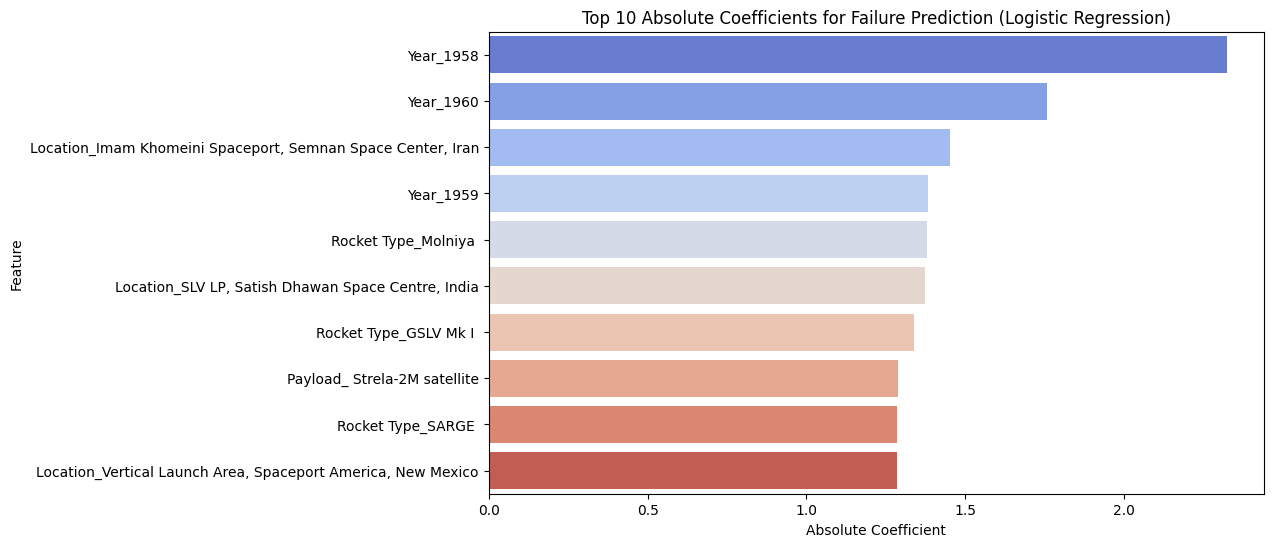

In [413]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get coefficients
coefficients = log_reg.coef_[0]

# Create a DataFrame to store coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()  # Absolute coefficients for better interpretation

# Sort the DataFrame by absolute coefficient values
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plotting absolute coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=coefficients_df.head(10), x='Abs_Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 10 Absolute Coefficients for Failure Prediction (Logistic Regression)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.show()

In [425]:
# Get top 5 maximum and minimum coefficients for each category
'''
top_max = {}
top_min = {}

for category in ['Payload', 'Month', 'Rocket Type', 'Year', 'Location','Month' ,'Season']:
    top_max[category] = coefficients_df[coefficients_df['Feature'].str.startswith(category)].nlargest(5, 'Coefficient')
    top_min[category] = coefficients_df[coefficients_df['Feature'].str.startswith(category)].nsmallest(5, 'Coefficient')

# Display top 5 maximum and minimum coefficients for each category
for category in ['Payload', 'Month','Rocket Type', 'Year', 'Location','Month' ,'Season' ]:
    print(f"Top maximum coefficients for {category}:")
    print(top_max[category])
    print(f"\nTop minimum coefficients for {category}:")
    print(top_min[category])
    print()
'''
coefficients = dict(zip(X.columns, log_reg.coef_[0]))
top_coefficients = {}
for column_prefix in ['Payload', 'Month', 'Rocket Type', 'Year', 'Location','Month' ,'Season']:
    # Filter coefficients related to the current category
    relevant_coeffs = {k: v for k, v in coefficients.items() if k.startswith(column_prefix)}
    # Sort coefficients by value
    sorted_coeffs = sorted(relevant_coeffs.items(), key=lambda item: item[1])
    # Get top 5 maximum and minimum coefficients
    top_max = dict(sorted_coeffs[-5:])
    top_min = dict(sorted_coeffs[:5])
    top_coefficients[column_prefix] = {'top_max': top_max, 'top_min': top_min}
for category, coeffs in top_coefficients.items():
    print(f"Top maximum coefficients for {category}:")
    for feature, coef in coeffs['top_max'].items():
        print(f"{feature}: {coef}")
    print(f"\nTop minimum coefficients for {category}:")
    for feature, coef in coeffs['top_min'].items():
        print(f"{feature}: {coef}")
    print()


Top maximum coefficients for Payload:
Payload_ Explorer 1: 0.4427376656923154
Payload_ Fajr: 0.44511267078905636
Payload_ Venera 1: 0.4898888046072984
Payload_ Vanguard 2: 0.5522358483896662
Payload_ Vanguard 1: 0.6878401451569661

Top minimum coefficients for Payload:
Payload_ Strela-2M satellite: -1.2867533200566417
Payload_ Unknown Payload: -1.040955581999934
Payload_ Zond: -1.009798639644373
Payload_ Ofek-4: -0.9360498136138188
Payload_ Superbird-B, BS-2X: -0.9084163743773872

Top maximum coefficients for Month:
Month_December: 0.06940024426264271
Month_August: 0.08099359619546975
Month_March: 0.12038924998278276
Month_October: 0.20553094196634314
Month_February: 0.29767037219031073

Top minimum coefficients for Month:
Month_June: -0.05782735505561157
Month_July: -0.03192412131491568
Month_November: -0.020076185229254397
Month_September: 0.00893052344991789
Month_May: 0.019222847358363614

Top maximum coefficients for Rocket Type:
Rocket Type_Pegasus XL : 0.7777559547571155
Rocket 

In [428]:
with open('top_coefficients_success.pkl', 'wb') as f:
    pickle.dump(top_coefficients, f)

In [429]:
top_coefficients 

{'Payload': {'top_max': {'Payload_ Explorer 1': 0.4427376656923154,
   'Payload_ Fajr': 0.44511267078905636,
   'Payload_ Venera 1': 0.4898888046072984,
   'Payload_ Vanguard 2': 0.5522358483896662,
   'Payload_ Vanguard 1': 0.6878401451569661},
  'top_min': {'Payload_ Strela-2M satellite': -1.2867533200566417,
   'Payload_ Unknown Payload': -1.040955581999934,
   'Payload_ Zond': -1.009798639644373,
   'Payload_ Ofek-4': -0.9360498136138188,
   'Payload_ Superbird-B, BS-2X': -0.9084163743773872}},
 'Month': {'top_max': {'Month_December': 0.06940024426264271,
   'Month_August': 0.08099359619546975,
   'Month_March': 0.12038924998278276,
   'Month_October': 0.20553094196634314,
   'Month_February': 0.29767037219031073},
  'top_min': {'Month_June': -0.05782735505561157,
   'Month_July': -0.03192412131491568,
   'Month_November': -0.020076185229254397,
   'Month_September': 0.00893052344991789,
   'Month_May': 0.019222847358363614}},
 'Rocket Type': {'top_max': {'Rocket Type_Pegasus XL ':

In [442]:
#df['Cost'].fillna(df['Cost'].median(),inplace=True)
df.to_excel("final.xlsx")

In [444]:
df

,Company Name,Location,Datum,Detail,Status Rocket,Status Mission,state,country,Rocket Type,Payload,Rocket Category,Year,Month,Season,Decade,Cost
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA",2020-08-07 05:12:00,Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,Active,Success,Florida,USA,Falcon 9 Block 5,Starlink V1 L9 & BlackSky,Falcon,2020,August,Summer,2020,50.00
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...",2020-08-06 04:01:00,Long March 2D | Gaofen-9 04 & Q-SAT,Active,Success,Jiuquan Satellite Launch Center,China,Long March 2D,Gaofen-9 04 & Q-SAT,Long March,2020,August,Summer,2020,29.75
2,SpaceX,"Pad A, Boca Chica, Texas, USA",2020-08-04 23:57:00,Starship Prototype | 150 Meter Hop,Active,Success,Texas,USA,Starship Prototype,150 Meter Hop,Starship,2020,August,Summer,2020,62.00
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan",2020-07-30 21:25:00,Proton-M/Briz-M | Ekspress-80 & Ekspress-103,Active,Success,Baikonur Cosmodrome,Kazakhstan,Proton-M/Briz-M,Ekspress-80 & Ekspress-103,Proton,2020,July,Summer,2020,65.00
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA",2020-07-30 11:50:00,Atlas V 541 | Perseverance,Active,Success,Florida,USA,Atlas V 541,Perseverance,Atlas,2020,July,Summer,2020,145.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1958-02-05 07:33:00,Vanguard | Vanguard TV3BU,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3BU,Vanguard,1958,February,Winter,1950,62.00
4324,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA",1958-02-01 03:48:00,Juno I | Explorer 1,Retired,Success,Florida,USA,Juno I,Explorer 1,Juno,1958,February,Winter,1950,62.00
4325,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA",1957-12-06 16:44:00,Vanguard | Vanguard TV3,Retired,Failure,Florida,USA,Vanguard,Vanguard TV3,Vanguard,1957,December,Winter,1950,62.00
4326,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan",1957-11-03 02:30:00,Sputnik 8K71PS | Sputnik-2,Retired,Success,Baikonur Cosmodrome,Kazakhstan,Sputnik 8K71PS,Sputnik-2,Sputnik,1957,November,Fall,1950,62.00
